In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor
from scipy import stats
import statsmodels.api as sm
import pymc as pm

In [2]:
data_dir = 'C:/crs/proj/2025_shoreline_fits/'
fn = 'Northshore_LT_intersects.csv'
df = pd.read_csv(data_dir+fn)

# Convert to datetime format
df["date"] = pd.to_datetime(df["ShorelineI"], format="%m/%d/%Y")

# Function to convert datetime to decimal year
def datetime_to_decimal_year(dt):
    year = dt.year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    end_of_year = pd.Timestamp(f"{year+1}-01-01")
    decimal_year = year + (dt - start_of_year).total_seconds() / (end_of_year - start_of_year).total_seconds()
    return decimal_year

# Apply function to convert each date
df["decimal_year"] = df["date"].apply(datetime_to_decimal_year)
df

,FID,OBJECTID,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,Bias_Dista,BIAS,BIAS_X,BIAS_Y,Bias_Uncer,date,decimal_year
0,0,1,1,1,1,07/01/1855,34.976190,352128.892960,4.750413e+06,10.80,41.522127,6.545937,352135.016503,4.750410e+06,11.257508,1855-07-01,1855.495890
1,1,2,1,1,1,07/01/1953,-27.896967,352070.076869,4.750435e+06,10.80,-21.351030,6.545937,352076.200410,4.750432e+06,11.257508,1953-07-01,1953.495890
2,2,3,1,1,1,09/30/2000,37.442543,352131.200165,4.750412e+06,2.26,37.442543,6.545937,352131.200165,4.750412e+06,2.260000,2000-09-30,2000.745902
3,3,4,2,2,1,07/01/1855,16.848559,352094.265039,4.750372e+06,10.80,23.394496,6.545937,352100.388583,4.750370e+06,11.257508,1855-07-01,1855.495890
4,4,5,2,2,1,07/01/1944,4.646185,352082.850052,4.750376e+06,10.80,11.192122,6.545937,352088.973596,4.750374e+06,11.257508,1944-07-01,1944.497268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27231,27231,27036,3740,3740,39,07/01/1893,-2.350970,337344.903873,4.691653e+06,10.80,-2.349970,0.001000,337344.902916,4.691653e+06,10.800000,1893-07-01,1893.495890
27232,27232,27037,3740,3740,39,07/01/1938,-11.054914,337353.232937,4.691656e+06,10.80,-11.053914,0.001000,337353.231980,4.691656e+06,10.800000,1938-07-01,1938.495890
27233,27233,27038,3740,3740,39,07/01/1978,-10.946378,337353.129075,4.691656e+06,5.10,-10.945378,0.001000,337353.128118,4.691656e+06,5.100000,1978-07-01,1978.495890
27234,27234,27039,3740,3740,39,10/01/1994,-5.199820,337347.630023,4.691654e+06,5.10,-5.198820,0.001000,337347.629066,4.691654e+06,5.100000,1994-10-01,1994.747945


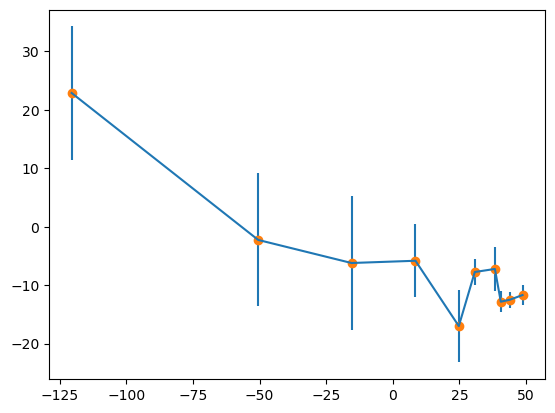

In [10]:
# pick a transect
tid = 2776
tdf = df[df["TransectID"] == tid]
x = tdf['decimal_year'].values - 1970.
y = tdf['Bias_Dista'].values
yu = tdf['Bias_Uncer'].values
plt.errorbar(x,y,yu)
plt.plot(x, y, 'o')

In [11]:
tdf['decimal_year'].values

array([1849.49589041, 1919.49589041, 1954.49589041, 1978.49589041,
       1994.74794521, 2000.74590164, 2008.28961749, 2010.50136986,
       2013.9369863 , 2018.66575342])

In [12]:
estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
]
colors = {"OLS": "brown", "Theil-Sen": "wheat", "RANSAC": "lavender"}
lw = 2

In [13]:
estimators[2]

('RANSAC', RANSACRegressor(random_state=42))

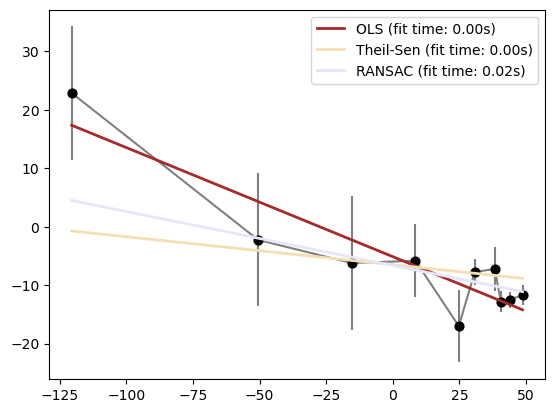

In [14]:
plt.errorbar(x, y, yu, c='gray', zorder=0)
plt.scatter(x, y, color="black", marker="o", s=40, zorder=1)
X = x[:, np.newaxis]
line_x = np.array([np.min(x), np.max(x)])
for name, estimator in estimators:
    t0 = time.time()
    reg = estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(
        line_x,
        y_pred,
        color=colors[name],
        linewidth=lw,
        label="%s (fit time: %.2fs)" % (name, elapsed_time),
    )
plt.axis("tight")
plt.legend(loc="upper right")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 72 seconds.


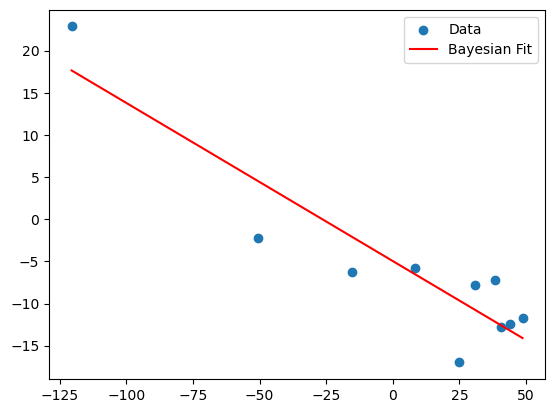

In [15]:
# Generate synthetic data
np.random.seed(42)

# Define Bayesian Model
with pm.Model() as model:
    # Priors for slope and intercept
    slope = pm.Normal("slope", mu=0, sigma=10)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=slope * x + intercept, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Extract posterior mean estimates
slope_post = trace.posterior["slope"].mean().values
intercept_post = trace.posterior["intercept"].mean().values

# Plot result
plt.scatter(x, y, label="Data")
plt.plot(x, slope_post * x + intercept_post, color="r", label="Bayesian Fit")
plt.legend()
plt.show()

In [63]:
Z = sm.add_constant(x)
print(Z)

[[   1.         -120.50410959]
 [   1.          -50.50410959]
 [   1.          -15.50410959]
 [   1.            8.49589041]
 [   1.           24.74794521]
 [   1.           30.74590164]
 [   1.           38.28961749]
 [   1.           40.50136986]
 [   1.           43.9369863 ]
 [   1.           48.66575342]]


In [60]:
print(OLSfit.conf_int(alpha=0.05, cols=None))

[[-0.25512329 -0.11797267]
 [-8.64892379 -1.60900705]]


In [61]:
dir(OLSfit)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 

Unweighted
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     39.35
Date:                Sun, 09 Mar 2025   Prob (F-statistic):           0.000240
Time:                        13:00:54   Log-Likelihood:                -28.770
No. Observations:                  10   AIC:                             61.54
Df Residuals:                       8   BIC:                             62.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1290      1.526     -3.3

C:\Users\csherwood\.conda\envs\CRS\lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)
C:\Users\csherwood\.conda\envs\CRS\lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


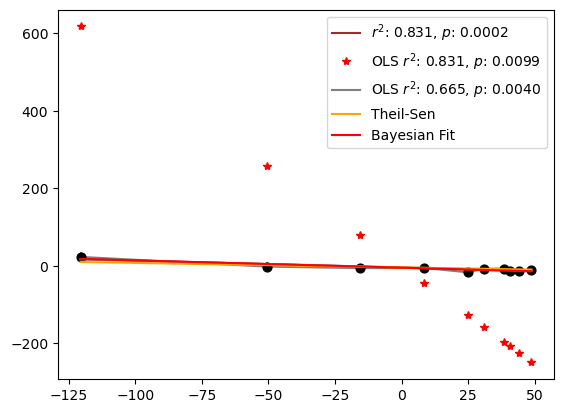

In [64]:
# Set up for statsmodels OLS and WLS
# need a column of ones to fit intercept
X = np.column_stack( (x, np.ones_like(x) ))
weights = 1./( yu**2 )



print('Unweighted')
OLSfit = sm.OLS(y, X).fit()
# Use dir(OLSfit) to see the attributes and methods
print(OLSfit.summary())
OLS_slope, OLS_intercept = OLSfit.params
OLS_pvalues = OLSfit.pvalues
OLStxt = r'OLS $r^2$: {:.3f}, $p$: {:.4f}'.format(OLSfit.rsquared, OLS_pvalues[0])

print('\n**********************************************\nWeighted')
WLSfit = sm.WLS(y, X, weights=weights).fit()
print(WLSfit.summary())
WLS_slope, WLS_intercept = WLSfit.params
WLS_pvalues = WLSfit.pvalues
WLStxt = r'OLS $r^2$: {:.3f}, $p$: {:.4f}'.format(WLSfit.rsquared, WLS_pvalues[0])

# Compare with scipy.stats model
res = stats.linregress( x, y )
txt = r'$r^2$: {:.3f}, $p$: {:.4f}'.format( res.rvalue**2, res.pvalue )
print(res)
# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
# Make the function:
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
ts = tinv(0.05, len(x)-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")

# Theil-Sen regression
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.theilslopes.html

res_theil = stats.theilslopes(y, x, alpha=0.95, method='separate' )
print(res_theil)
plt.errorbar(x, y, yu, c='gray', zorder=0)
plt.scatter(x, y, color="black", marker="o", s=40, zorder=1)
plt.plot(x, res.intercept + res.slope*x, c = 'brown', label = txt )
plt.plot(x, OLS_intercept + OLS_slope*x, '*r', label = OLStxt )
plt.plot(x, WLS_intercept + WLS_slope*x, c = 'gray', label = WLStxt )

plt.plot(x, res_theil.intercept + res_theil.slope*x, c = 'orange', label = 'Theil-Sen' )

# need to run the previous cell for this to work
plt.plot(x, slope_post * x + intercept_post, color="r", label="Bayesian Fit")
plt.legend()